In [1]:
!pip install -q numpy pandas scikit-learn lightgbm catboost joblib mlflow

In [2]:
# 1) === CONFIGURACIÓN DE ENTORNO ===> Imports y utilidades
import os, sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib



In [3]:
try:
    import mlflow
    import mlflow.sklearn
    import os
    from pathlib import Path


    tracking_path = Path("mlruns").resolve()
    mlflow.set_tracking_uri(f"file:///{tracking_path}".replace("\\", "/"))
    mlflow.set_experiment("MLflow_Quickstart")

    MLflow_AVAILABLE = True
    print(f"Conectado a MLflow existente en: {mlflow.get_tracking_uri()}")

except Exception as e:
    MLflow_AVAILABLE = False
    print("MLflow no disponible o no se pudo conectar:", e)



def safe_rmse(y_true, y_pred):
    """Calcula RMSE con manejo de errores."""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_regression(y_true, y_pred, model_name="Modelo"):
    """
    Calcula MAE, RMSE y R², y registra las métricas en MLflow
    si está conectado y hay un run activo.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = safe_rmse(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"{model_name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")


    if MLflow_AVAILABLE:
        try:
            with mlflow.start_run(run_name=model_name):
                mlflow.log_metrics(metrics)
            print(f" Métricas registradas en MLflow bajo el run '{model_name}'.")
        except Exception as e:
            print("No se pudieron registrar métricas en MLflow:", e)

    return metrics


def print_eval(name, m):
    """Imprime las métricas en formato legible."""
    print(f"{name} -> MAE: {m['MAE']:.3f} | RMSE: {m['RMSE']:.3f} | R²: {m['R2']:.3f}")



Conectado a MLflow existente en: file:///C:/Users/eduar/operaciones-de-aprendizaje-automatico-equipo59/scripts/mlruns


In [4]:
COLAB_DATA_PATH = Path('/content/work_absenteeism_clean.csv')
LOCAL_DATA_PATH = Path('../AbsenteeismAtWork/data/work_absenteeism_clean.csv')

def resolve_paths():
    in_colab = 'google.colab' in sys.modules
    base_dir = None
    if in_colab:
        try:
            from google.colab import drive
            drive.mount('/content/drive', force_remount=True)
            base_dir = Path('/content/drive/MyDrive/Colab Notebooks/MNA/MLOPS')
        except Exception as e:
            print('No se pudo montar Drive, usando ruta local. Error:', e)
            base_dir = Path('.')
    else:
        base_dir = Path('.')
    models_dir = base_dir / 'models'
    mlruns_dir = base_dir / 'mlruns'
    models_dir.mkdir(parents=True, exist_ok=True)
    mlruns_dir.mkdir(parents=True, exist_ok=True)
    return base_dir, models_dir, mlruns_dir

BASE_DIR, MODELS_DIR, MLRUNS_DIR = resolve_paths()
print('BASE_DIR:', BASE_DIR)
print('MODELS_DIR:', MODELS_DIR)
print('MLRUNS_DIR:', MLRUNS_DIR)

def load_dataset():
    try:
        if COLAB_DATA_PATH.exists():
            df_ = pd.read_csv(COLAB_DATA_PATH)
            print('Cargado desde ruta Colab:', COLAB_DATA_PATH)
            return df_
    except Exception as e:
        print('Falló lectura Colab path:', e)
    try:
        if LOCAL_DATA_PATH.exists():
            df_ = pd.read_csv(LOCAL_DATA_PATH)
            print('Cargado desde ruta local:', LOCAL_DATA_PATH)
            return df_
    except Exception as e:
        print('Falló lectura Local path:', e)
    raise FileNotFoundError('No se encontró el dataset en ninguna ruta conocida.')

df = load_dataset()
print('Dimensiones:', df.shape)
df.head()


BASE_DIR: .
MODELS_DIR: models
MLRUNS_DIR: mlruns
Cargado desde ruta local: ..\AbsenteeismAtWork\data\work_absenteeism_clean.csv
Dimensiones: (754, 20)


,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,240,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,240,97,1,1,1,1,0,0,98,176,31,0
2,23,7,4,1,179,51,18,38,240,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,240,97,0,1,2,1,1,0,68,168,24,4
4,23,7,2,1,289,36,13,33,240,97,0,1,2,1,0,1,90,172,30,2


In [5]:
TARGET = 'Absenteeism time in hours'
assert TARGET in df.columns, f"No se encontró la columna objetivo '{TARGET}'. Columnas: {df.columns.tolist()}"

df = df.drop_duplicates().copy()
X = df.drop(columns=[TARGET])
y = df[TARGET]

cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

if not cat_cols:
    candidates = ['Reason for absence','Month of absence','Day of the week','Seasons','Education','Social drinker','Social smoker']
    cat_cols = [c for c in candidates if c in X.columns]
    for c in cat_cols:
        X[c] = X[c].astype('category')

print('Categoricas:', cat_cols)
print('Numericas  :', num_cols)


Categoricas: ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Education', 'Social drinker', 'Social smoker']
Numericas  : ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day', 'Hit target', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']


In [6]:
# Division de Datos
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"Split -> Train: {X_train.shape}, Test: {X_test.shape}")

Split -> Train: (583, 19), Test: (146, 19)


In [7]:
# Preprocesamiento
numeric_tf = Pipeline([('scaler', StandardScaler())])
categorical_tf = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categorical_tf, cat_cols)
])

In [8]:
# Funcion de Evaluacion
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n🔹 {name} Results:")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")

    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'ModelObject': pipe}

results = []


In [9]:
# Random Forest
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
results.append(evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test))


🔹 Random Forest Results:
MAE:  2.612
RMSE: 3.775
R²:   0.344


In [10]:
# CatBoost
cb = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=8, random_state=42, verbose=0)
results.append(evaluate_model("CatBoost", cb, X_train, X_test, y_train, y_test))


🔹 CatBoost Results:
MAE:  2.709
RMSE: 3.816
R²:   0.330


In [11]:
# LightGBM
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=50,
    min_child_samples=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    force_col_wise=True,
    boosting_type='gbdt'
)


results.append(
    evaluate_model("LightGBM", lgbm, X_train, X_test, y_train, y_test)
)

[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 583, number of used features: 66
[LightGBM] [Info] Start training from score 5.166381

🔹 LightGBM Results:
MAE:  2.993
RMSE: 4.316
R²:   0.143


c:\Users\eduar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [12]:
# Resultados de Modelos
results_df = pd.DataFrame(results).drop(columns=['ModelObject'])
display(results_df.sort_values(by='RMSE'))

,Model,MAE,RMSE,R2
0,Random Forest,2.612297,3.775265,0.34412
1,CatBoost,2.708630,3.815941,0.32991
2,LightGBM,2.992765,4.315723,0.14289


C:\Users\eduar\AppData\Local\Temp\ipykernel_26008\623384699.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='RMSE', palette='coolwarm')


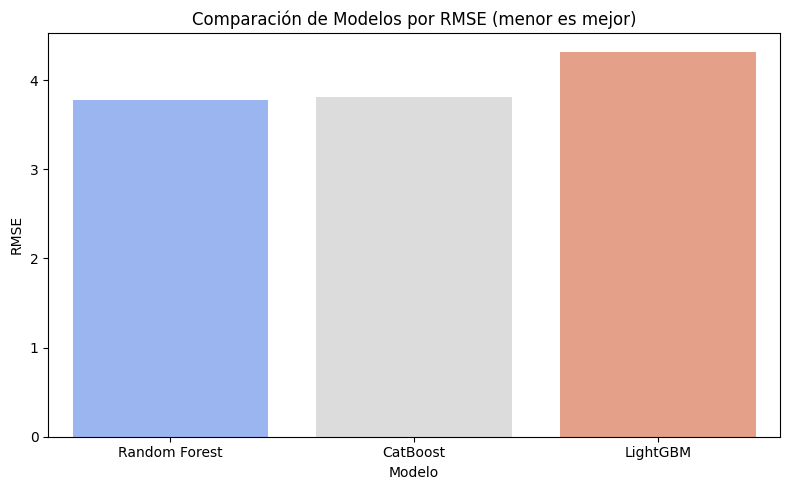

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='RMSE', palette='coolwarm')
plt.title('Comparación de Modelos por RMSE (menor es mejor)')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [14]:
# Ajustando Hiperparametros al mejor modelo:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

param_dist = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': [8, 10, 12, None],
    'model__min_samples_split': randint(2, 6),
    'model__min_samples_leaf': randint(1, 3)
}

pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

rs_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

print("Iniciando RandomizedSearchCV")
rs_rf.fit(X_train, y_train)

best_params = rs_rf.best_params_
best_cv_rmse = -rs_rf.best_score_

print("\n Mejores parámetros encontrados:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"\n Mejor RMSE promedio (CV): {best_cv_rmse:.4f}")


best_rf = rs_rf.best_estimator_
pred_best = best_rf.predict(X_test)
best_metrics = evaluate_regression(y_test, pred_best)
print("\n RandomForest (tuned):", best_metrics)


Iniciando RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Mejores parámetros encontrados:
  model__max_depth: 8
  model__min_samples_leaf: 2
  model__min_samples_split: 5
  model__n_estimators: 393

 Mejor RMSE promedio (CV): 3.4985
Modelo -> MAE: 2.588 | RMSE: 3.723 | R²: 0.362
 Métricas registradas en MLflow bajo el run 'Modelo'.

 RandomForest (tuned): {'MAE': 2.588320846474571, 'RMSE': np.float64(3.7229925848112253), 'R2': 0.36215669324731126}


In [15]:
# Resultados con Hiperparametros
best_rf = rs_rf.best_estimator_
y_pred_best = best_rf.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("\nRendimiento final en datos:")
print(f"MAE:  {mae_best:.3f}")
print(f"RMSE: {rmse_best:.3f}")
print(f"R²:   {r2_best:.3f}")

results.append({
    'Model': 'Random Forest (Tuned)',
    'MAE': mae_best,
    'RMSE': rmse_best,
    'R2': r2_best,
    'ModelObject': best_rf
})



Rendimiento final en datos:
MAE:  2.588
RMSE: 3.723
R²:   0.362


In [16]:
[i["Model"] for i in results]


['Random Forest', 'CatBoost', 'LightGBM', 'Random Forest (Tuned)']

In [17]:
# Comparacion con modelo base y el nuevo:


rf_base = next(r for r in results if r["Model"] == "Random Forest")
rf_tuned = next(r for r in results if r["Model"] == "Random Forest (Tuned)")


improvement_rmse = ((rf_base["RMSE"] - rf_tuned["RMSE"]) / rf_base["RMSE"]) * 100
improvement_mae = ((rf_base["MAE"] - rf_tuned["MAE"]) / rf_base["MAE"]) * 100
improvement_r2 = (rf_tuned["R2"] - rf_base["R2"]) * 100

print("\nComparación :")
print(f"• RMSE Base : {rf_base['RMSE']:.3f}")
print(f"• RMSE Tuned: {rf_tuned['RMSE']:.3f}")
print(f"• Mejora relativa en RMSE: {improvement_rmse:.2f}%")

print(f"\n• MAE Base : {rf_base['MAE']:.3f}")
print(f"• MAE Tuned: {rf_tuned['MAE']:.3f}")
print(f"• Mejora relativa en MAE: {improvement_mae:.2f}%")

print(f"\n• R² Base : {rf_base['R2']:.3f}")
print(f"• R² Tuned: {rf_tuned['R2']:.3f}")
print(f"• Cambio en R²: {improvement_r2:.2f} puntos porcentuales")



Comparación :
• RMSE Base : 3.775
• RMSE Tuned: 3.723
• Mejora relativa en RMSE: 1.38%

• MAE Base : 2.612
• MAE Tuned: 2.588
• Mejora relativa en MAE: 0.92%

• R² Base : 0.344
• R² Tuned: 0.362
• Cambio en R²: 1.80 puntos porcentuales


C:\Users\eduar\AppData\Local\Temp\ipykernel_26008\2152176161.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Modelo', y='RMSE', palette='mako')


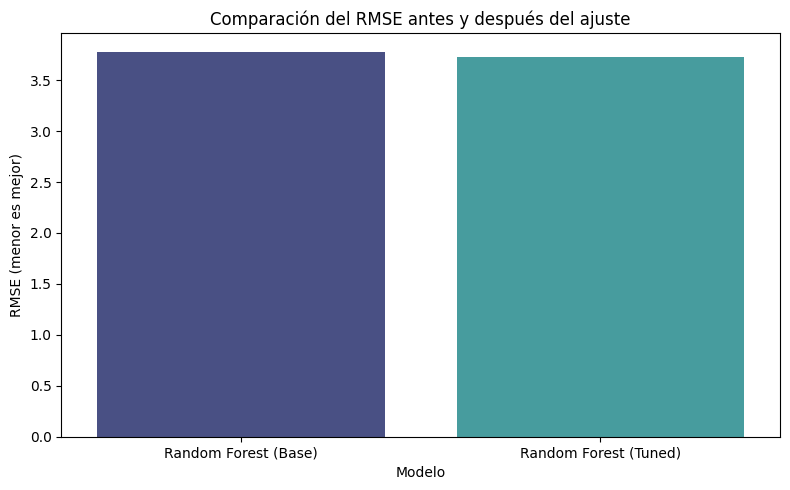

,Modelo,MAE,RMSE,R²
0,Random Forest (Base),2.612297,3.775265,0.344120
1,Random Forest (Tuned),2.588321,3.722993,0.362157


In [18]:
# Comparacion con modelo base y el nuevo:


rf_base = next(r for r in results if r["Model"] == "Random Forest")
base_mae = rf_base['MAE']
base_rmse = rf_base['RMSE']
base_r2 = rf_base['R2']

metrics_df = pd.DataFrame({
    'Modelo': ['Random Forest (Base)', 'Random Forest (Tuned)'],
    'MAE': [base_mae, mae_best],
    'RMSE': [base_rmse, rmse_best],
    'R²': [base_r2, r2_best]
})

plt.figure(figsize=(8,5))
sns.barplot(data=metrics_df, x='Modelo', y='RMSE', palette='mako')
plt.title('Comparación del RMSE antes y después del ajuste')
plt.ylabel('RMSE (menor es mejor)')
plt.tight_layout()
plt.show()

display(metrics_df)

In [19]:
# === Registro en MLflow (config adaptable) ===
if MLflow_AVAILABLE:
    try:
        import os
        from pathlib import Path

        # Obtiene tracking URI desde variable de entorno o crea una local relativa
        tracking_uri = os.getenv(
            "MLFLOW_TRACKING_URI",
            "file://" + str(Path("mlruns").resolve()).replace("\\", "/")
        )

        #  Conexión al experimento (si no existe, MLflow lo crea)
        mlflow.set_tracking_uri(tracking_uri)
        mlflow.set_experiment("MLflow_Quickstart")

        # Nuevo run para registrar tu modelo
        with mlflow.start_run(run_name="RandomForest_Tuned"):
            mlflow.log_params(best_params)
            mlflow.log_metrics({
                "MAE_Test": best_metrics["MAE"],
                "RMSE_Test": best_metrics["RMSE"],
                "R2_Test": best_metrics["R2"]
            })
            mlflow.sklearn.log_model(best_rf, "RandomForest_Tuned")

        print(f" Modelo registrado en experimento 'MLflow_Quickstart'")
        print(f"Tracking URI: {tracking_uri}")

    except Exception as e:
        print(" No se pudo registrar en MLflow:", e)
else:
    print(" MLflow no está disponible. Saltando registro.")

2025/10/12 17:43:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/12 17:43:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Modelo registrado en experimento 'MLflow_Quickstart'
Tracking URI: file:///C:/Users/eduar/operaciones-de-aprendizaje-automatico-equipo59/scripts/mlruns
